In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import torch.distributions

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))



Using cuda device


# Data generation

Geometrical figures of random position, shape and color

Random Color:


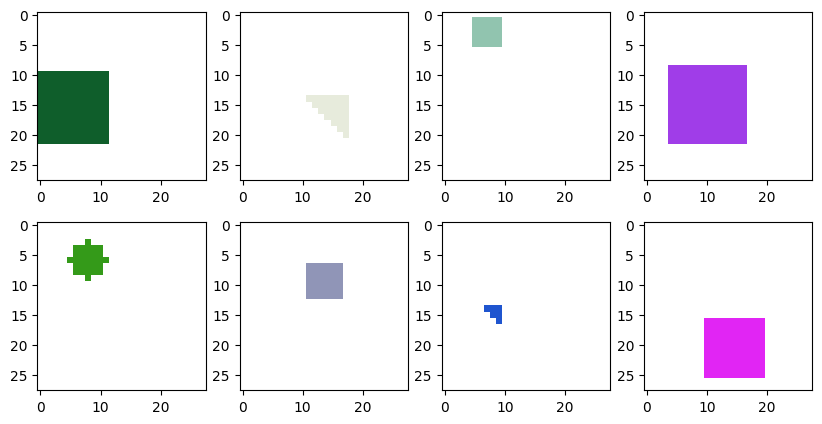

In [2]:


class GeometricFiguresDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=60000, image_size=(28, 28), random_color=True):
        self.num_samples = num_samples
        self.image_size = image_size
        self.random_color = random_color

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.generate_image()
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        label_tensor = torch.tensor(label)
        return image_tensor, label_tensor

    def generate_image(self):
        image = np.ones((self.image_size[0], self.image_size[1], 3), dtype=np.uint8) * 255  # White background

        shape = np.random.choice(['square', 'circle', 'triangle'])
        color = self.choose_color()
        size = np.random.randint(3, self.image_size[0] // 2)
        pos_x = np.random.randint(0, self.image_size[1] - size)
        pos_y = np.random.randint(0, self.image_size[0] - size)

        if shape == 'square':
            image = self.draw_square(image, x = pos_x, y = pos_y,  size=size, color=color)
        elif shape=='circle':
            image = self.draw_circle(image, x = pos_x, y = pos_y, radius=size//2, color=color)
        else:
            image = self.draw_triangle(image, x = pos_x, y = pos_y, size=size, color=color)

        #label is the shape, color, size and position of the shape
        shape_dict = {'square': 0, 'circle': 1, 'triangle': 2}
        label = np.array([shape_dict[shape],  size, pos_x, pos_y, color[0], color[1], color[2]])


        return image, label

    def choose_color(self):
        if self.random_color:
            return np.random.randint(0, 256, size=3)  # Random RGB color
        else:
            color_r = np.array([255, 0, 0])
            color_g = np.array([0, 255, 0])
            color_b = np.array([0, 0, 255])
            rand_col = np.random.randint(0, 3)
            if rand_col == 0:
                return color_r
            elif rand_col == 1:
                return color_g
            else:
                return color_b


    def draw_square(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color
        return image

    def draw_triangle(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color

        # Determine whether to remove upper or lower half of the square
        if np.random.rand() < 0.5:
            # Remove upper half of the square
            for i in range(size):
                for j in range(size):
                    if i > j:
                        image[y+i, x+j] = 255  # Background color
        else:
            # Remove lower half of the square
            for i in range(size):
                for j in range(size):
                    if i < j:
                        image[y+i, x+j] = 255  # Background color
        return image

    def draw_circle(self, image, x, y, radius, color):

        yy, xx = np.ogrid[-y:image.shape[0]-y, -x:image.shape[1]-x]
        mask = xx*xx + yy*yy <= radius*radius
        image[mask] = color
        return image


class GeometricFiguresDatasetBlackWhite(GeometricFiguresDataset):
    def __init__(self, num_samples=60000, image_size=(28, 28)):
        super().__init__(num_samples, image_size, random_color=False)

    def choose_color(self):
        return np.array([0, 0, 0])  # Black color

    def __getitem__(self, idx):
        img, label =  super().__getitem__(idx)
        img = img[0]  # Take only one channel
        img = img/255.0  # Normalize
        return img, label




dataset_random_color = GeometricFiguresDataset(random_color=True)
dataloader_random_color = torch.utils.data.DataLoader(dataset_random_color, batch_size=8, shuffle=True)

# Visualize some samples with random color
print("Random Color:")
for batch in dataloader_random_color:
    batch = batch[0]
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch


In [3]:
batch_size = 128

dataset = GeometricFiguresDataset(random_color=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Convolutional autoencoder

get a sence of how complex our model should be

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 50):
            super(Encoder, self).__init__()
            self.latent_dim = latent_dim

            encoder_channels = [input_channels] + encoder_channels
            self.encoder_channels = encoder_channels

            self.conv_layers = nn.ModuleList()
            for i in range(len(encoder_channels)-1):
                self.conv_layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=2))
                self.conv_layers.append(nn.BatchNorm2d(encoder_channels[i+1]))
                self.conv_layers.append(nn.ReLU())

            self.flatten = nn.Flatten()
            self.fc = nn.Linear(10000, self.latent_dim) #if you define this on fly in the forward function, it will not be ported to a device and will cause an error


    def forward(self, x, debug_shape = False):
        for layer in self.conv_layers:
            x = layer(x)
            if debug_shape:
                print(x.shape)

        x = self.flatten(x)
        if debug_shape: print(x.shape)

        x = self.fc(x)
        if debug_shape: print(x.shape)

        return x

class Decoder(nn.Module):
    def __init__(self, enc_channels, latent_dim, enc_conv_shape):
        super(Decoder, self).__init__()
        self.decoder_channels = enc_channels[::-1]

        self.fc = nn.Linear(latent_dim, enc_conv_shape[0]*enc_conv_shape[1]*enc_conv_shape[2])
        self.unflatten = nn.Unflatten(1, enc_conv_shape)

        self.fc2 = nn.Linear(28*28*3, 3*28*28) #if you define this on fly in the forward function, it will not be ported to a device and will cause an error
        self.sigmoid = nn.Sigmoid()


        self.deconv_layers = nn.ModuleList()
        for i in range(len(self.decoder_channels)-1):
            self.deconv_layers.append(nn.ConvTranspose2d(self.decoder_channels[i], self.decoder_channels[i+1], kernel_size=2))
            self.deconv_layers.append(nn.BatchNorm2d(self.decoder_channels[i+1]))
            self.deconv_layers.append(nn.ReLU())



    def forward(self, x, debug_shape=False):
        x = self.fc(x)
        x = self.unflatten(x)

        for layer in self.deconv_layers:
            x = layer(x)
            if debug_shape: print(x.shape)

        x = x.flatten(1)
        if debug_shape: print(x.shape)

        x = self.fc2(x)
        if debug_shape: print(x.shape)
        x = self.sigmoid(x)
        if debug_shape: print(x.shape)
        x = x.view(-1, 3, 28, 28)
        if debug_shape: print(x.shape)
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 100):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(input_channels, encoder_channels, latent_dim = latent_dim)
        latent_dim = latent_dim
        output_conv_shape = torch.Size([encoder_channels[-1], 25, 25])
        encoder_channels = [input_channels] + encoder_channels
        self.decoder = Decoder(encoder_channels, latent_dim, output_conv_shape)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

torch.Size([128, 4, 27, 27])
torch.Size([128, 4, 27, 27])
torch.Size([128, 4, 27, 27])
torch.Size([128, 8, 26, 26])
torch.Size([128, 8, 26, 26])
torch.Size([128, 8, 26, 26])
torch.Size([128, 16, 25, 25])
torch.Size([128, 16, 25, 25])
torch.Size([128, 16, 25, 25])
torch.Size([128, 10000])
torch.Size([128, 100])
torch.Size([128, 8, 26, 26])
torch.Size([128, 8, 26, 26])
torch.Size([128, 8, 26, 26])
torch.Size([128, 4, 27, 27])
torch.Size([128, 4, 27, 27])
torch.Size([128, 4, 27, 27])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 2352])
torch.Size([128, 2352])
torch.Size([128, 2352])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
tensor(0.6891, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.3360, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.2810, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.7132, device='cuda:0', grad_fn=<MinBackward1>)


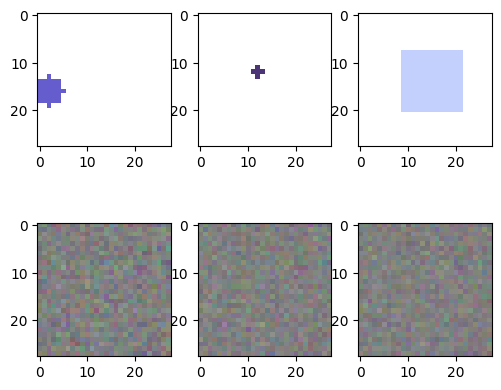

In [11]:

# Define model parameters
input_channels = 3  # RGB channels
encoder_channels = [4, 8, 16]    #shpuld be like 8,16,32 ...
latent_dim = 100

model = ConvAutoencoder(input_channels, encoder_channels, latent_dim)
criterion = nn.MSELoss()

model = model.to(device)
criterion = criterion.to(device)

model.encoder.forward(next(iter(dataloader))[0].to(device), debug_shape=True)
model.decoder.forward(torch.rand(128, 100).to(device), debug_shape=True)


random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model(random_batch)

print(output.shape)
assert output.shape == random_batch.shape, f"Expected output shape {random_batch.shape} but got {output.shape}"


plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


o1 = output[0]
o2 = output[1]

print(o1.max(), o1.min(), (o1/o2).max(), (o1/o2).min())

In [14]:
# Training loop
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader_random_color.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/5], Loss: 0.0009
Epoch [2/5], Loss: 0.0007
Epoch [3/5], Loss: 0.0005
Epoch [4/5], Loss: 0.0005
Epoch [5/5], Loss: 0.0004


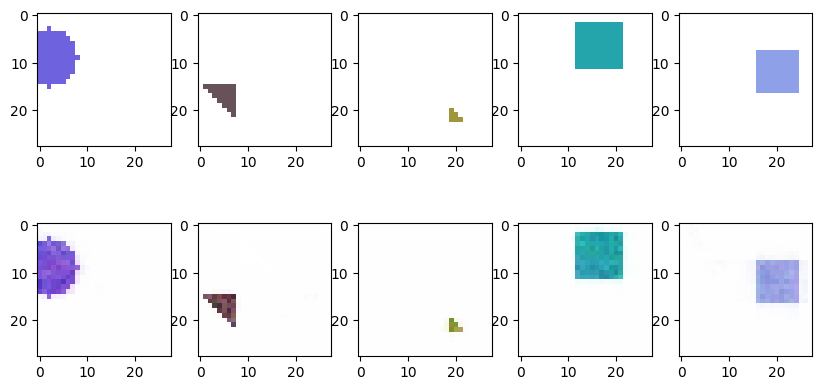

In [18]:
random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model(random_batch)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
